# ARIMA FOR AMAZON SPOT PRICE PREDICTION

### IMPORT ALL HEADER FILES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import  Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


### IMPORT DATA

In [2]:
data = pd.read_csv("Dataset/US/us-east-1.csv", usecols=(0,2,4), parse_dates=['datetime'], 
                   index_col=['datetime'])

In [3]:
data.head()

,os,price
datetime,,
2017-05-08 21:38:41,SUSE Linux,0.2770
2017-05-08 21:38:41,Linux/UNIX,0.1770
2017-05-08 21:38:37,SUSE Linux,0.4061
2017-05-08 21:38:37,Linux/UNIX,0.3061
2017-05-08 21:38:37,SUSE Linux,0.8234


In [4]:
data.dtypes

os        object
price    float64
dtype: object

###Segregate date based on OS type

In [5]:
data_win = data.loc[data.iloc[:,0] == "Windows"]
data_unix = data.loc[data.iloc[:,0] == "Linux/UNIX"]
data_linux = data.loc[data.iloc[:,0] == "SUSE Linux"]

###Resample each dataset with 15min and split into test and train

In [6]:
win_sample = data_win.price.resample('15min').mean()
lin_sample = data_linux.price.resample('15min').mean()
uni_sample = data_unix.price.resample('15min').mean()

In [7]:
win_sample = win_sample.to_frame()
lin_sample = lin_sample.to_frame()
uni_sample = uni_sample.to_frame()

In [8]:
win_sample = win_sample.price.values
win_sample = win_sample.reshape(-1,1)
win_sample.shape

(1178, 1)

In [9]:
lin_sample = lin_sample.price.values
lin_sample = lin_sample.reshape(-1,1)
lin_sample.shape

(1178, 1)

In [10]:
uni_sample = uni_sample.price.values
uni_sample = uni_sample.reshape(-1,1)
uni_sample.shape

(1178, 1)

In [11]:
win_train = np.array(win_sample[:int(win_sample.shape[0]*0.8)])
win_test = np.array(win_sample[:int(win_sample.shape[0]*0.2)])
lin_train = np.array(lin_sample[:int(lin_sample.shape[0]*0.8)])
lin_test = np.array(lin_sample[:int(lin_sample.shape[0]*0.2)])
uni_train = np.array(uni_sample[:int(uni_sample.shape[0]*0.8)])
uni_test = np.array(uni_sample[:int(uni_sample.shape[0]*0.2)])


###Normalizing data to scal between (0,1)

In [12]:
scalar = MinMaxScaler(feature_range=(0,1))
win_train = scalar.fit_transform(win_train)
win_test = scalar.fit_transform(win_test)
lin_train = scalar.fit_transform(lin_train)
lin_test = scalar.fit_transform(lin_test)
uni_train = scalar.fit_transform(uni_train)
uni_test = scalar.fit_transform(uni_test)

### Create Supervised data from timeseries data

In [13]:
def create_dataset(dataset, previous):
    data_X, data_Y = [], []
    for i in range(len(dataset)-previous-1):
        a = dataset[i:(i+previous),0]
        data_X.append(a)
        data_Y.append(dataset[i+previous,0])
        
    return np.array(data_X), np.array(data_Y)

In [14]:
previous = 1
trainX_win, trainY_win = create_dataset(win_train, previous)
testX_win, testY_win = create_dataset(win_test, previous)
trainX_lin, trainY_lin = create_dataset(lin_train, previous)
testX_lin, testY_lin = create_dataset(lin_test, previous)
trainX_uni, trainY_uni = create_dataset(uni_train, previous)
testX_uni, testY_uni = create_dataset(uni_test, previous)

In [15]:
trainX_uni.shape

(940, 1)

In [16]:
trainX_win = np.reshape(trainX_win, (trainX_win.shape[0], 1, trainX_win.shape[1]))
testX_win = np.reshape(testX_win, (testX_win.shape[0], 1, testX_win.shape[1]))
trainX_lin = np.reshape(trainX_lin, (trainX_lin.shape[0], 1, trainX_lin.shape[1]))
testX_lin = np.reshape(testX_lin, (testX_lin.shape[0], 1, testX_lin.shape[1]))
trainX_uni = np.reshape(trainX_uni, (trainX_uni.shape[0], 1, trainX_uni.shape[1]))
testX_uni = np.reshape(testX_uni, (testX_uni.shape[0], 1, testX_uni.shape[1]))

###Build Model function

In [17]:
def build_model(X_train):
    model = Sequential()
    model.add(LSTM(32, input_shape=(X_train.shape[1],1), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1))

    model.summary()
    
    return (model)

###Compile Model function

In [18]:
def compile_model(model, x_train, y_train, x_test, y_test):
    
    model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mse'])

    history = model.fit(x_train,y_train, batch_size=32, epochs=50, 
                        validation_data=(x_test,y_test))

    return history

###LSTM for Windows

In [19]:
win_model = build_model(trainX_win)
history = compile_model(win_model, trainX_win, trainY_win, testX_win, testY_win)
win_model.save('win_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 32)             4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


Train on 940 samples, validate on 233 samples
Epoch 1/50


 32/940 [>.............................] - ETA: 37s - loss: 0.0085 - mean_squared_error: 0.0085

768/940 [=======================>......] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053 

940/940 [==============================] - 2s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 2/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017

576/940 [=================>............] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

940/940 [==============================] - 0s 107us/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 3/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

384/940 [===========>..................] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

940/940 [==============================] - 0s 111us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 4/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016

480/940 [==============>...............] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

940/940 [==============================] - 0s 122us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 5/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

320/940 [=========>....................] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017

736/940 [======================>.......] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

940/940 [==============================] - 0s 158us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 6/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

416/940 [============>.................] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

940/940 [==============================] - 0s 117us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 7/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012

576/940 [=================>............] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

940/940 [==============================] - 0s 116us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 8/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

256/940 [=======>......................] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017

736/940 [======================>.......] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

940/940 [==============================] - 0s 146us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 9/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019

608/940 [==================>...........] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019

940/940 [==============================] - 0s 101us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0059 - val_mean_squared_error: 0.0059


Epoch 10/50
 32/940 [>.............................] - ETA: 0s - loss: 8.7255e-04 - mean_squared_error: 8.7255e-04

576/940 [=================>............] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034        

940/940 [==============================] - 0s 106us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 11/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.0014

608/940 [==================>...........] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

940/940 [==============================] - 0s 103us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 12/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.0018

544/940 [================>.............] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

940/940 [==============================] - 0s 108us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 13/50
 32/940 [>.............................] - ETA: 0s - loss: 7.8047e-04 - mean_squared_error: 7.8047e-04



576/940 [=================>............] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.0015        

940/940 [==============================] - 0s 111us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 14/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.0014

608/940 [==================>...........] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

940/940 [==============================] - 0s 101us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0059 - val_mean_squared_error: 0.0059


Epoch 15/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

640/940 [===================>..........] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

940/940 [==============================] - 0s 99us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 16/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

672/940 [====================>.........] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

940/940 [==============================] - 0s 105us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 17/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

576/940 [=================>............] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017

940/940 [==============================] - 0s 114us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 18/50
 32/940 [>.............................] - ETA: 0s - loss: 8.0860e-04 - mean_squared_error: 8.0860e-04

416/940 [============>.................] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037        

940/940 [==============================] - 0s 118us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 19/50
 32/940 [>.............................] - ETA: 0s - loss: 8.2210e-04 - mean_squared_error: 8.2210e-04

544/940 [================>.............] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034        

940/940 [==============================] - 0s 105us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 20/50
 32/940 [>.............................] - ETA: 0s - loss: 9.9968e-04 - mean_squared_error: 9.9968e-04

576/940 [=================>............] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016        

940/940 [==============================] - 0s 101us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 21/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011

544/940 [================>.............] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016

940/940 [==============================] - 0s 107us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 22/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016

576/940 [=================>............] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016

940/940 [==============================]

 - 0s 102us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 23/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013

576/940 [=================>............] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016

940/940 [==============================] - 0s 105us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 24/50
 32/940 [>.............................] - ETA: 0s - loss: 6.9014e-04 - mean_squared_error: 6.9014e-04

384/940 [===========>..................] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017        

640/940 [===================>..........] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017

940/940 [==============================] - 0s 179us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 25/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0012 - mean_squared_error: 0.0012

480/940 [==============>...............] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

940/940 [==============================] - 0s 118us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 26/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019

544/940 [================>.............] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

940/940 [==============================] - 0s 109us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 27/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011

544/940 [================>.............] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

940/940 [==============================] - 0s 107us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 28/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011

608/940 [==================>...........] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

940/940 [==============================] - 0s 105us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 29/50
 32/940 [>.............................] - ETA: 0s - loss: 5.6417e-04 - mean_squared_error: 5.6417e-04

448/940 [=============>................] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016        

928/940 [============================>.] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

940/940 [==============================] - 0s 129us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0057 - val_mean_squared_error: 0.0057


Epoch 30/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

640/940 [===================>..........] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

940/940 [==============================] - 0s 95us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0058 - val_mean_squared_error: 0.0058


Epoch 31/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.0015

576/940 [=================>............] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.0018

940/940 [==============================] - 0s 102us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 32/50
 32/940 [>.............................] - ETA: 0s - loss: 8.9426e-04 - mean_squared_error: 8.9426e-04

640/940 [===================>..........] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017        

940/940 [==============================] - 0s 95us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 33/50
 32/940 [>.............................] - ETA: 0s - loss: 8.2037e-04 - mean_squared_error: 8.2037e-04

672/940 [====================>.........] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032        

940/940 [==============================] - 0s 97us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 34/50
 32/940 [>.............................] - ETA: 0s - loss: 8.9146e-04 - mean_squared_error: 8.9146e-04

608/940 [==================>...........] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032        

940/940 [==============================] - 0s 101us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 35/50
 32/940 [>.............................] - ETA: 0s - loss: 5.9318e-04 - mean_squared_error: 5.9318e-04

608/940 [==================>...........] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016        

940/940 [==============================] - 0s 94us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 36/50
 32/940 [>.............................] - ETA: 0s - loss: 9.8049e-04 - mean_squared_error: 9.8049e-04

704/940 [=====================>........] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016        

940/940 [==============================] - 0s 90us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 37/50


 32/940 [>.............................] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

608/940 [==================>...........] - ETA: 0s - loss: 0.0015 - mean_squared_error: 0.0015

940/940 [==============================] - 0s 97us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 38/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

576/940 [=================>............] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

940/940 [==============================] - 0s 98us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 39/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010

672/940 [====================>.........] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

940/940 [==============================] - 0s 92us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


Epoch 40/50
 32/940 [>.............................] - ETA: 0s - loss: 8.1917e-04 - mean_squared_error: 8.1917e-04

544/940 [================>.............] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017        

896/940 [===========================>..] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

940/940 [==============================] - 0s 146us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 41/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022

544/940 [================>.............] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

940/940 [==============================] - 0s 122us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


Epoch 42/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0010 - mean_squared_error: 0.0010

576/940 [=================>............] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

940/940 [==============================] - 0s 105us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 43/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

608/940 [==================>...........] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016

940/940 [==============================] - 0s 104us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 44/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0011 - mean_squared_error: 0.0011

576/940 [=================>............] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017

940/940 [==============================] - 0s 108us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


Epoch 45/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013

608/940 [==================>...........] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

940/940 [==============================] - 0s 100us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 46/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013

576/940 [=================>............] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019

940/940 [==============================] - 0s 102us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


Epoch 47/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0016 - mean_squared_error: 0.0016

512/940 [===============>..............] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.0014

940/940 [==============================] - 0s 116us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


Epoch 48/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

576/940 [=================>............] - ETA: 0s - loss: 0.0031 - mean_squared_error: 0.0031

940/940 [==============================] - 0s 106us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


Epoch 49/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

544/940 [================>.............] - ETA: 0s - loss: 0.0018 - mean_squared_error: 0.0018

940/940 [==============================] - 0s 112us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


Epoch 50/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0014 - mean_squared_error: 0.0014

416/940 [============>.................] - ETA: 0s - loss: 0.0013 - mean_squared_error: 0.0013

940/940 [==============================] - 0s 121us/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0055 - val_mean_squared_error: 0.0055


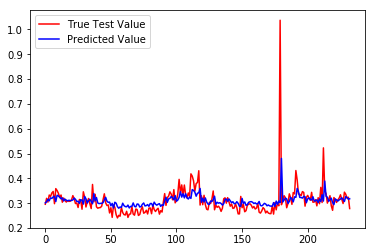

In [20]:
pred_win = win_model.predict(testX_win)

pred_win = scalar.inverse_transform(pred_win)

testY_win_scale = scalar.inverse_transform(testY_win.reshape(-1,1))

fig,ax = plt.subplots()
plt.plot(testY_win_scale, color ='red', label = "True Test Value")
ax.plot(pred_win, color = 'blue',label = 'Predicted Value')
plt.legend()

#####MSE-Windows

In [21]:
mse_win = np.mean(np.square(testY_win_scale - pred_win))
print(mse_win)

0.003463619670334221


#####RMSE Windows

In [22]:
rmse_win = np.sqrt(mse_win)
print(rmse_win)

0.058852524757517594


#####MAE-Windows

In [23]:
mae = np.mean(np.absolute(testY_win_scale-pred_win))
print(mae)

0.027184494498092158


###MSE Plot for Windows

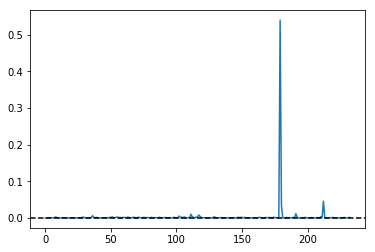

In [24]:
mse_plot_win = np.square(testY_win_scale - pred_win)
#print(testY_win_scale)
plt.plot(mse_plot_win)
plt.axhline(y=0,linestyle='--',color='black')

###LSTM for Linux

In [25]:
lin_model = build_model(trainX_lin)
history_lin = compile_model(lin_model, trainX_lin, trainY_lin, testX_lin, testY_lin)
lin_model.save('lin_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 32)             4352      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


Train on 940 samples, validate on 233 samples
Epoch 1/50


 32/940 [>.............................] - ETA: 44s - loss: 0.0093 - mean_squared_error: 0.0093

672/940 [====================>.........] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.0127 

940/940 [==============================] - 2s 2ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


Epoch 2/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

512/940 [===============>..............] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

940/940 [==============================] - 0s 104us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0106 - val_mean_squared_error: 0.0106


Epoch 3/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0072 - mean_squared_error: 0.0072

576/940 [=================>............] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

940/940 [==============================] - 0s 95us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0115 - val_mean_squared_error: 0.0115


Epoch 4/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

576/940 [=================>............] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

940/940 [==============================] - 0s 99us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0117 - val_mean_squared_error: 0.0117


Epoch 5/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0219 - mean_squared_error: 0.0219

544/940 [================>.............] - ETA: 0s - loss: 0.0093 - mean_squared_error: 0.0093

940/940 [==============================] - 0s 114us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0111 - val_mean_squared_error: 0.0111


Epoch 6/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.0131

608/940 [==================>...........] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

940/940 [==============================] - 0s 104us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0113 - val_mean_squared_error: 0.0113


Epoch 7/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0034 - mean_squared_error: 0.0034

608/940 [==================>...........] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

940/940 [==============================] - 0s 107us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0114 - val_mean_squared_error: 0.0114


Epoch 8/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

608/940 [==================>...........] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

940/940 [==============================] - 0s 100us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0110 - val_mean_squared_error: 0.0110


Epoch 9/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

544/940 [================>.............] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

940/940 [==============================] - 0s 106us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0112 - val_mean_squared_error: 0.0112


Epoch 10/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0280 - mean_squared_error: 0.0280



544/940 [================>.............] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

940/940 [==============================] - 0s 127us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0117 - val_mean_squared_error: 0.0117


Epoch 11/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056

512/940 [===============>..............] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

940/940 [==============================] - 0s 119us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0113 - val_mean_squared_error: 0.0113


Epoch 12/50


 32/940 [>.............................] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039

544/940 [================>.............] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

928/940 [============================>.] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

940/940 [==============================] - 0s 135us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0109 - val_mean_squared_error: 0.0109


Epoch 13/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

384/940 [===========>..................] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

768/940 [=======================>......] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

940/940 [==============================] - 0s 154us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0113 - val_mean_squared_error: 0.0113


Epoch 14/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0113 - mean_squared_error: 0.0113

544/940 [================>.............] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

940/940 [==============================] - 0s 109us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0110 - val_mean_squared_error: 0.0110


Epoch 15/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0114 - mean_squared_error: 0.0114

608/940 [==================>...........] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

940/940 [==============================] - 0s 102us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0114 - val_mean_squared_error: 0.0114


Epoch 16/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0182 - mean_squared_error: 0.0182

512/940 [===============>..............] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

940/940 [==============================] - 0s 110us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0111 - val_mean_squared_error: 0.0111


Epoch 17/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0052 - mean_squared_error: 0.0052

544/940 [================>.............] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

940/940 [==============================] - 0s 112us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0109 - val_mean_squared_error: 0.0109


Epoch 18/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

544/940 [================>.............] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

940/940 [==============================] - 0s 119us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 19/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

576/940 [=================>............] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

940/940 [==============================] - 0s 105us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0108 - val_mean_squared_error: 0.0108


Epoch 20/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

512/940 [===============>..............] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

940/940 [==============================] - 0s 109us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0111 - val_mean_squared_error: 0.0111


Epoch 21/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

576/940 [=================>............] - ETA: 0s - loss: 0.0100 - mean_squared_error: 0.0100

940/940 [==============================] - 0s 101us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0107 - val_mean_squared_error: 0.0107


Epoch 22/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

608/940 [==================>...........] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

940/940 [==============================] - 0s 106us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 23/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0037

576/940 [=================>............] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

940/940 [==============================] - 0s 107us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0099 - val_mean_squared_error: 0.0099


Epoch 24/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

544/940 [================>.............] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

940/940 [==============================] - 0s 105us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0101 - val_mean_squared_error: 0.0101


Epoch 25/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

576/940 [=================>............] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

940/940 [==============================] - 0s 106us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0106 - val_mean_squared_error: 0.0106


Epoch 26/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0029 - mean_squared_error: 0.0029

576/940 [=================>............] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

940/940 [==============================] - 0s 105us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0107 - val_mean_squared_error: 0.0107


Epoch 27/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0127 - mean_squared_error: 0.0127

544/940 [================>.............] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

940/940 [==============================] - 0s 106us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


Epoch 28/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0143 - mean_squared_error: 0.0143

512/940 [===============>..............] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

940/940 [==============================] - 0s 119us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0104 - val_mean_squared_error: 0.0104


Epoch 29/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0091

576/940 [=================>............] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

940/940 [==============================] - 0s 108us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0098 - val_mean_squared_error: 0.0098


Epoch 30/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

544/940 [================>.............] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

940/940 [==============================] - 0s 118us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 31/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

608/940 [==================>...........] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

940/940 [==============================] - 0s 105us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0109 - val_mean_squared_error: 0.0109


Epoch 32/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

608/940 [==================>...........] - ETA: 0s - loss: 0.0092 - mean_squared_error: 0.0092

940/940 [==============================] - 0s 104us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 33/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

608/940 [==================>...........] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

940/940 [==============================] - 0s 102us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 34/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0110 - mean_squared_error: 0.0110

608/940 [==================>...........] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

940/940 [==============================] - 0s 106us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


Epoch 35/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

576/940 [=================>............] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

940/940 [==============================] - 0s 112us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0104 - val_mean_squared_error: 0.0104


Epoch 36/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

608/940 [==================>...........] - ETA: 0s - loss: 0.0066 - mean_squared_error: 0.0066

940/940 [==============================] - 0s 103us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 37/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

608/940 [==================>...........] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

940/940 [==============================] - 0s 105us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0107 - val_mean_squared_error: 0.0107


Epoch 38/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

608/940 [==================>...........] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

940/940 [==============================] - 0s 105us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0111 - val_mean_squared_error: 0.0111


Epoch 39/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

544/940 [================>.............] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

940/940 [==============================] - 0s 116us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0104 - val_mean_squared_error: 0.0104


Epoch 40/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

384/940 [===========>..................] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

864/940 [==========================>...] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

940/940 [==============================] - 0s 131us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 41/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

576/940 [=================>............] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

940/940 [==============================] - 0s 104us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0107 - val_mean_squared_error: 0.0107


Epoch 42/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

544/940 [================>.............] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

940/940 [==============================] - 0s 106us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0098 - val_mean_squared_error: 0.0098


Epoch 43/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

544/940 [================>.............] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

940/940 [==============================] - 0s 107us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 44/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0102 - mean_squared_error: 0.0102

544/940 [================>.............] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

940/940 [==============================] - 0s 105us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 45/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

544/940 [================>.............] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

940/940 [==============================] - 0s 108us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0098 - val_mean_squared_error: 0.0098


Epoch 46/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0043 - mean_squared_error: 0.0043

608/940 [==================>...........] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

940/940 [==============================] - 0s 104us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0097 - val_mean_squared_error: 0.0097


Epoch 47/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

576/940 [=================>............] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

940/940 [==============================] - 0s 105us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0101 - val_mean_squared_error: 0.0101


Epoch 48/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.0224

576/940 [=================>............] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

940/940 [==============================] - 0s 107us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0101 - val_mean_squared_error: 0.0101


Epoch 49/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0050 - mean_squared_error: 0.0050

544/940 [================>.............] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

940/940 [==============================] - 0s 111us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0099 - val_mean_squared_error: 0.0099


Epoch 50/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0269 - mean_squared_error: 0.0269

544/940 [================>.............] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

940/940 [==============================] - 0s 118us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0100 - val_mean_squared_error: 0.0100


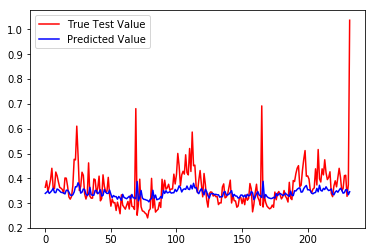

In [26]:
pred_lin = lin_model.predict(testX_lin)

pred_lin = scalar.inverse_transform(pred_lin)

testY_lin_scale = scalar.inverse_transform(testY_lin.reshape(-1,1))

fig,ax = plt.subplots()
plt.plot(testY_lin_scale, color ='red', label = "True Test Value")
ax.plot(pred_lin, color = 'blue',label = 'Predicted Value')
plt.legend()

#####MSE-Linux

In [27]:
mse_lin = np.mean(np.square(testY_lin_scale - pred_lin))
print(mse_lin)

0.006351192650955178


#####RMSE-Linux

In [28]:
rmse_lin = np.sqrt(mse_lin)
print(rmse_lin)

0.07969437025885315


#####MAE-Linux

In [29]:
mae_lin = np.mean(np.absolute(testY_lin_scale-pred_lin))
print(mae_lin)

0.047719484984757185


###MSE Plot for Linux

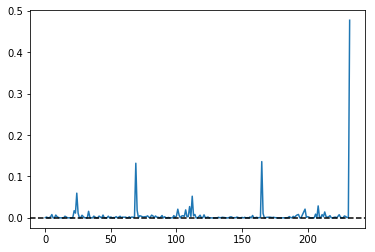

In [30]:
mse_plot_lin = np.square(testY_lin_scale - pred_lin)
#print(testY_win_scale)
plt.plot(mse_plot_lin)
plt.axhline(y=0,linestyle='--',color='black')

###LSTM for Unix

In [31]:
uni_model = build_model(trainX_uni)
history_uni = compile_model(uni_model, trainX_uni, trainY_uni, testX_uni, testY_uni)
uni_model.save('uni_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 32)             4352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


Train on 940 samples, validate on 233 samples
Epoch 1/50


 32/940 [>.............................] - ETA: 49s - loss: 0.0221 - mean_squared_error: 0.0221

704/940 [=====================>........] - ETA: 0s - loss: 0.0126 - mean_squared_error: 0.0126 

940/940 [==============================] - 2s 2ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0109 - val_mean_squared_error: 0.0109


Epoch 2/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0027 - mean_squared_error: 0.0027

512/940 [===============>..............] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

940/940 [==============================] - 0s 108us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0113 - val_mean_squared_error: 0.0113


Epoch 3/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0046 - mean_squared_error: 0.0046

576/940 [=================>............] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

940/940 [==============================] - 0s 99us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0112 - val_mean_squared_error: 0.0112


Epoch 4/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0363 - mean_squared_error: 0.0363

576/940 [=================>............] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095



940/940 [==============================] - 0s 102us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0117 - val_mean_squared_error: 0.0117


Epoch 5/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

576/940 [=================>............] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

940/940 [==============================] - 0s 117us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0112 - val_mean_squared_error: 0.0112


Epoch 6/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

576/940 [=================>............] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

940/940 [==============================] - 0s 107us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0108 - val_mean_squared_error: 0.0108


Epoch 7/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0024 - mean_squared_error: 0.0024

576/940 [=================>............] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

940/940 [==============================] - 0s 109us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0113 - val_mean_squared_error: 0.0113


Epoch 8/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

576/940 [=================>............] - ETA: 0s - loss: 0.0064 - mean_squared_error: 0.0064

940/940 [==============================] - 0s 109us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0104 - val_mean_squared_error: 0.0104


Epoch 9/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

416/940 [============>.................] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

896/940 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075

940/940 [==============================] - 0s 135us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0111 - val_mean_squared_error: 0.0111


Epoch 10/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

416/940 [============>.................] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063



940/940 [==============================] - 0s 119us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0115 - val_mean_squared_error: 0.0115


Epoch 11/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0048 - mean_squared_error: 0.0048

544/940 [================>.............] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085

940/940 [==============================] - 0s 112us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0112 - val_mean_squared_error: 0.0112


Epoch 12/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.0033

576/940 [=================>............] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

940/940 [==============================] - 0s 111us/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0110 - val_mean_squared_error: 0.0110


Epoch 13/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0285 - mean_squared_error: 0.0285

576/940 [=================>............] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0091

940/940 [==============================] - 0s 107us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0112 - val_mean_squared_error: 0.0112


Epoch 14/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0118 - mean_squared_error: 0.0118

480/940 [==============>...............] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

940/940 [==============================] - 0s 108us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 15/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0035 - mean_squared_error: 0.0035

512/940 [===============>..............] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

940/940 [==============================] - 0s 122us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 16/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0020 - mean_squared_error: 0.0020

576/940 [=================>............] - ETA: 0s - loss: 0.0089 - mean_squared_error: 0.0089

940/940 [==============================] - 0s 105us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0101 - val_mean_squared_error: 0.0101


Epoch 17/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

544/940 [================>.............] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

940/940 [==============================] - 0s 111us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


Epoch 18/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0023 - mean_squared_error: 0.0023

608/940 [==================>...........] - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0074

940/940 [==============================] - 0s 102us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0104 - val_mean_squared_error: 0.0104


Epoch 19/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0153 - mean_squared_error: 0.0153

576/940 [=================>............] - ETA: 0s - loss: 0.0078 - mean_squared_error: 0.0078

940/940 [==============================] - 0s 110us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0108 - val_mean_squared_error: 0.0108


Epoch 20/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

576/940 [=================>............] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

940/940 [==============================] - 0s 107us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0110 - val_mean_squared_error: 0.0110


Epoch 21/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

448/940 [=============>................] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

940/940 [==============================] - 0s 115us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0108 - val_mean_squared_error: 0.0108


Epoch 22/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

512/940 [===============>..............] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.0095

940/940 [==============================] - 0s 114us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0108 - val_mean_squared_error: 0.0108


Epoch 23/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019

576/940 [=================>............] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

940/940 [==============================] - 0s 104us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0098 - val_mean_squared_error: 0.0098


Epoch 24/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

544/940 [================>.............] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

940/940 [==============================] - 0s 112us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 25/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0091 - mean_squared_error: 0.0091

576/940 [=================>............] - ETA: 0s - loss: 0.0070 - mean_squared_error: 0.0070

940/940 [==============================] - 0s 107us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 26/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0275 - mean_squared_error: 0.0275

576/940 [=================>............] - ETA: 0s - loss: 0.0085 - mean_squared_error: 0.0085



940/940 [==============================] - 0s 107us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 27/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

512/940 [===============>..............] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

940/940 [==============================] - 0s 108us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0106 - val_mean_squared_error: 0.0106


Epoch 28/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041

544/940 [================>.............] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

940/940 [==============================] - 0s 111us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0107 - val_mean_squared_error: 0.0107


Epoch 29/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0121 - mean_squared_error: 0.0121

544/940 [================>.............] - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.0088

928/940 [============================>.] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

940/940 [==============================] - 0s 125us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 30/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0025 - mean_squared_error: 0.0025

576/940 [=================>............] - ETA: 0s - loss: 0.0060 - mean_squared_error: 0.0060

940/940 [==============================] - 0s 109us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


Epoch 31/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0041 - mean_squared_error: 0.0041



576/940 [=================>............] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

940/940 [==============================] - 0s 109us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0111 - val_mean_squared_error: 0.0111


Epoch 32/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0040 - mean_squared_error: 0.0040

480/940 [==============>...............] - ETA: 0s - loss: 0.0082 - mean_squared_error: 0.0082

940/940 [==============================] - 0s 118us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0100 - val_mean_squared_error: 0.0100


Epoch 33/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0045 - mean_squared_error: 0.0045

608/940 [==================>...........] - ETA: 0s - loss: 0.0076 - mean_squared_error: 0.0076

940/940 [==============================] - 0s 118us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


Epoch 34/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0090 - mean_squared_error: 0.0090

512/940 [===============>..............] - ETA: 0s - loss: 0.0105 - mean_squared_error: 0.0105

940/940 [==============================] - 0s 110us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0108 - val_mean_squared_error: 0.0108


Epoch 35/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0207 - mean_squared_error: 0.0207

576/940 [=================>............] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061

940/940 [==============================] - 0s 103us/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0101 - val_mean_squared_error: 0.0101


Epoch 36/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026

576/940 [=================>............] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

940/940 [==============================] - 0s 111us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 37/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

352/940 [==========>...................] - ETA: 0s - loss: 0.0096 - mean_squared_error: 0.0096

800/940 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_squared_error: 0.0080

940/940 [==============================] - 0s 144us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0101 - val_mean_squared_error: 0.0101


Epoch 38/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0087 - mean_squared_error: 0.0087

512/940 [===============>..............] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

940/940 [==============================] - 0s 112us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0102 - val_mean_squared_error: 0.0102


Epoch 39/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047

544/940 [================>.............] - ETA: 0s - loss: 0.0071 - mean_squared_error: 0.0071

940/940 [==============================] - 0s 109us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0104 - val_mean_squared_error: 0.0104


Epoch 40/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0036 - mean_squared_error: 0.0036

544/940 [================>.............] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

940/940 [==============================] - 0s 109us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0098 - val_mean_squared_error: 0.0098


Epoch 41/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

576/940 [=================>............] - ETA: 0s - loss: 0.0097 - mean_squared_error: 0.0097

940/940 [==============================] - 0s 103us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0105 - val_mean_squared_error: 0.0105


Epoch 42/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

544/940 [================>.............] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

940/940 [==============================] - 0s 105us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0100 - val_mean_squared_error: 0.0100


Epoch 43/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

512/940 [===============>..............] - ETA: 0s - loss: 0.0081 - mean_squared_error: 0.0081

940/940 [==============================] - 0s 117us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0103 - val_mean_squared_error: 0.0103


Epoch 44/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038

544/940 [================>.............] - ETA: 0s - loss: 0.0083 - mean_squared_error: 0.0083

940/940 [==============================] - 0s 114us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0107 - val_mean_squared_error: 0.0107


Epoch 45/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032

576/940 [=================>............] - ETA: 0s - loss: 0.0062 - mean_squared_error: 0.0062

940/940 [==============================] - 0s 106us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0097 - val_mean_squared_error: 0.0097


Epoch 46/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0030 - mean_squared_error: 0.0030

608/940 [==================>...........] - ETA: 0s - loss: 0.0069 - mean_squared_error: 0.0069

940/940 [==============================] - 0s 104us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0099 - val_mean_squared_error: 0.0099


Epoch 47/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0021 - mean_squared_error: 0.0021

544/940 [================>.............] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

940/940 [==============================] - 0s 110us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0106 - val_mean_squared_error: 0.0106


Epoch 48/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

608/940 [==================>...........] - ETA: 0s - loss: 0.0077 - mean_squared_error: 0.0077

940/940 [==============================] - 0s 102us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0098 - val_mean_squared_error: 0.0098


Epoch 49/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0028 - mean_squared_error: 0.0028

480/940 [==============>...............] - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.0079

940/940 [==============================] - 0s 115us/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0100 - val_mean_squared_error: 0.0100


Epoch 50/50
 32/940 [>.............................] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017

608/940 [==================>...........] - ETA: 0s - loss: 0.0086 - mean_squared_error: 0.0086

940/940 [==============================] - 0s 111us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0100 - val_mean_squared_error: 0.0100


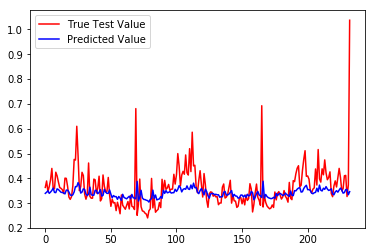

In [32]:
pred_uni = uni_model.predict(testX_uni)

pred_uni = scalar.inverse_transform(pred_uni)

testY_uni_scale = scalar.inverse_transform(testY_uni.reshape(-1,1))

fig,ax = plt.subplots()
plt.plot(testY_uni_scale, color ='red', label = "True Test Value")
ax.plot(pred_uni, color = 'blue',label = 'Predicted Value')
plt.legend()

#####MSE-Unix

In [33]:
mse_uni = np.mean(np.square(testY_uni_scale - pred_uni))
print(mse_uni)

0.006313754740934539


#####RMSE-Unix

In [34]:
rmse_uni = np.sqrt(mse_uni)
print(rmse_uni)

0.07945913881319466


#####MAE-Unix

In [35]:
mae_uni = np.mean(np.absolute(testY_uni_scale-pred_uni))
print(mae_uni)

0.047472961656846814


###MSE Plot for Unix

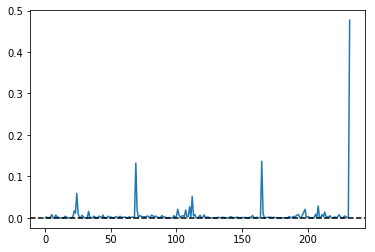

In [36]:
mse_plot_uni = np.square(testY_uni_scale - pred_uni)
#print(testY_win_scale)
plt.plot(mse_plot_uni)
plt.axhline(y=0,linestyle='--',color='black')